# Multiclass Classification on Tabular Data

### Re-implementation from [Daniel Bourke](https://www.learnpytorch.io/02_pytorch_classification/#8-putting-things-together-by-building-a-multi-class-pytorch-model)

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torchmetrics
from sklearn.datasets import make_blobs
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

RANDOM_SEED = 100  # for reproduceability in torch.randn()

In [2]:
def plot_decision_boundary(model, X, y):
    # Port everything to CPU
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/ 
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), 
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else: 
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary
    
    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

## Assemble Data

In [3]:
NUM_FEATURES = 2  # (x, y) coords of blobs
NUM_CLASSES = 4  # blobs can be any of 4 colors

# generate blob data
X, y = make_blobs(n_samples=1000,
                  n_features=NUM_FEATURES,
                  centers=NUM_CLASSES,  # number of classes
                  cluster_std=1.5,
                  random_state=RANDOM_SEED)

# convert to tensors
X = torch.from_numpy(X).to(torch.float32)
y = torch.from_numpy(y).to(torch.int64)

In [4]:
X.shape

torch.Size([1000, 2])

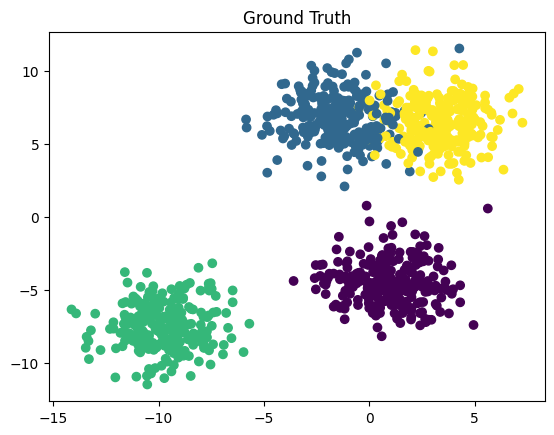

In [5]:
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y);
plt.title('Ground Truth');

In [6]:
# split dataset
train_split = int(0.8 * len(X)) # 80% of data used for training set, 10% for validation, 10% for testing
dev_split = int(0.9 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_dev, y_dev = X[train_split:dev_split], y[train_split:dev_split]
X_test, y_test = X[dev_split:], y[dev_split:]

len(X_train), len(X_dev), len(X_test)

(800, 100, 100)

In [7]:
# classification evaluation metric
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

## Build Model

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
class BlobClassifier(nn.Module):
    def __init__(self, input_features, output_features, hidden_units):
        """Initializes all required hyperparameters for model"""
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )
    
    def forward(self, x):
        """forward propagation"""
        return self.layers(x)

In [10]:
model = BlobClassifier(input_features=NUM_FEATURES, output_features=NUM_CLASSES, hidden_units=8).to(device)

In [11]:
model.parameters

<bound method Module.parameters of BlobClassifier(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)>

## Train Model

In [12]:
# create a loss function
loss_fn = nn.CrossEntropyLoss() 

# optimizer will update parameters with gradients calculated from backpropagation
# optim = torch.optim.SGD(params=model.parameters(), lr=0.01)
optim = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [13]:
torch.manual_seed(RANDOM_SEED)

accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES)

# for tracking learning
train_loss_values = []
dev_loss_values = []
epoch_count = []


# ----------- train loop -----------
for epoch in range(100):
    # "training" mode
    model.train()
    
    # forward pass 
    y_logits = model(X_train.to(device))
    # convert logits -> prediction probabilities -> prediction labels
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) 
    
    # calculate loss & accuracy
    loss = loss_fn(y_logits, y_train)
    accuracy = accuracy_fn(y_pred, y_train)
    
    # clear optimizer accumulation
    optim.zero_grad()
    
    # calcualte gradients via backpropagation
    loss.backward()
    
    # update parameters
    optim.step()
    
    # ----------- validation -----------
    if epoch % 10 == 0:
        with torch.inference_mode():
            # forward pass
            y_logits_dev = model(X_dev.to(device))
            y_pred_dev = torch.softmax(y_logits_dev, dim=1).argmax(dim=1) 

            loss_dev = loss_fn(y_logits_dev, y_dev)
        
        train_loss_values += [loss.detach().numpy()]
        dev_loss_values += [loss_dev.detach().numpy()]
        epoch_count += [epoch]
        
        print(f"Epoch: {epoch}\
        | Train Loss: {loss.detach().numpy():.5f}\
        | Dev Loss: {loss_dev.detach().numpy():.5f}\
        | Accuracy: {accuracy:.3f}")

Epoch: 0        | Train Loss: 1.29160        | Dev Loss: 1.10007        | Accuracy: 24.500
Epoch: 10        | Train Loss: 0.74089        | Dev Loss: 0.68028        | Accuracy: 65.500
Epoch: 20        | Train Loss: 0.57715        | Dev Loss: 0.55268        | Accuracy: 87.875
Epoch: 30        | Train Loss: 0.48343        | Dev Loss: 0.47057        | Accuracy: 92.125
Epoch: 40        | Train Loss: 0.41265        | Dev Loss: 0.40437        | Accuracy: 93.750
Epoch: 50        | Train Loss: 0.35721        | Dev Loss: 0.35113        | Accuracy: 94.750
Epoch: 60        | Train Loss: 0.31368        | Dev Loss: 0.30875        | Accuracy: 96.125
Epoch: 70        | Train Loss: 0.27932        | Dev Loss: 0.27499        | Accuracy: 96.125
Epoch: 80        | Train Loss: 0.25198        | Dev Loss: 0.24794        | Accuracy: 96.000
Epoch: 90        | Train Loss: 0.22999        | Dev Loss: 0.22607        | Accuracy: 96.000


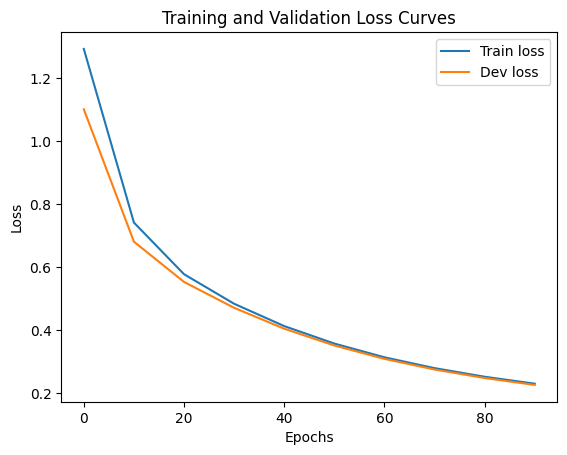

In [14]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, dev_loss_values, label="Dev loss")
plt.title("Training and Validation Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [15]:
# ----------- test loop -----------
test_loss_values = []

for i in range(len(X_test)):
    with torch.inference_mode():
        # forward pass
        y_logits_test = model(X_test).to(device)
        y_pred_test = torch.softmax(y_logits_test, dim=1).argmax(dim=1) 

        loss_test = loss_fn(y_logits_test, y_test)

In [16]:
# compare validation loss to test loss
print(loss_dev)
print(loss_test)

tensor(0.2261)
tensor(0.2003)


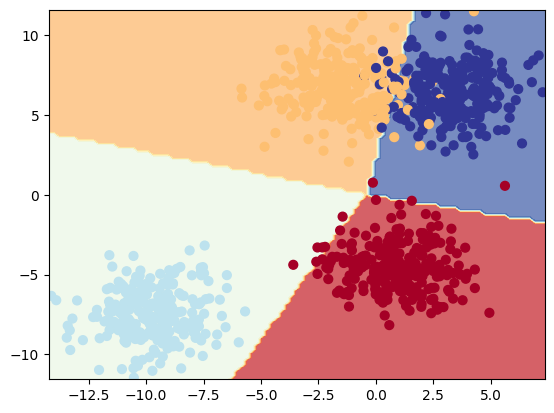

In [17]:
plot_decision_boundary(model, X, y)

Seems reasonable enough!